In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# GEOGRAPHIC DISTANCE CALCULATION USING GEOPY
# =============================================================================
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

geolocator = Nominatim(user_agent="myGeocoder")

def estimate_distance(destination_city, destination_state, origin_city="PORTLAND", origin_state="ME"):
    """
    Estimate the geographic distance in miles from the origin to the destination
    using geopy's Nominatim geocoder and geodesic distance.
    """
    origin_address = f"{origin_city}, {origin_state}"
    destination_address = f"{destination_city}, {destination_state}"
    try:
        origin_location = geolocator.geocode(origin_address)
        destination_location = geolocator.geocode(destination_address)
        if origin_location is None or destination_location is None:
            print("Geocoding failed for one or both locations.")
            return 0
        origin_coords = (origin_location.latitude, origin_location.longitude)
        destination_coords = (destination_location.latitude, destination_location.longitude)
        distance_km = geodesic(origin_coords, destination_coords).kilometers
        distance_miles = distance_km * 0.621371
        return distance_miles
    except Exception as e:
        print("Error in geocoding:", e)
        return 0

# =============================================================================
# DATA LOADING
# =============================================================================

def load_data(single_file_path, multi_file_path):
    """Load single-stop and multi-stop Excel data files."""
    single_df = pd.read_excel(single_file_path)
    multi_df = pd.read_excel(multi_file_path)
    print(f"Loaded {len(single_df)} single-stop records and {len(multi_df)} multi-stop records.")
    return single_df, multi_df

def load_third_data(third_file_path):
    """
    Load the 'Updated_Weather_CH Robinson.xlsx'.
    Create a 'Total Cost' column by summing 'Linehaul/ Shipment' and 'Fuel/ Shipment'.
    """
    third_df = pd.read_excel(third_file_path)
    print(f"Loaded third dataset with {len(third_df)} records.")

    third_df["Linehaul/ Shipment"] = pd.to_numeric(third_df["Linehaul/ Shipment"], errors="coerce").fillna(0)
    third_df["Fuel/ Shipment"] = pd.to_numeric(third_df["Fuel/ Shipment"], errors="coerce").fillna(0)
    third_df["Total Cost"] = third_df["Linehaul/ Shipment"] + third_df["Fuel/ Shipment"]

    return third_df

# =============================================================================
# DATA CLEANING & FEATURE ENGINEERING
# =============================================================================

def clean_single_data(df):
    """Clean and engineer features for the single-stop data."""
    df['Ship Date'] = pd.to_datetime(df['Ship Date'])
    df['Year'] = df['Ship Date'].dt.year
    df['Month'] = df['Ship Date'].dt.month
    df = df[(df['Total'] > 0) & df['Mileage'].notna() & df['Weight'].notna()].copy()
    return df

def clean_multi_data(df):
    """Clean and engineer features for the multi-stop data, handling up to 4 stops."""
    df['Ship Date'] = pd.to_datetime(df['Ship Date'])
    df['Year'] = df['Ship Date'].dt.year
    df['Month'] = df['Ship Date'].dt.month

    weight_cols = ["Weight", "Weight-1", "Weight-2", "Weight-3"]
    pallet_cols = ["Pallets", "Pallets-1", "Pallets-2", "Pallets-3"]
    mileage_cols = ["Mileage", "Mileage-1", "Mileage-2", "Mileage-3"]

    for col in weight_cols + pallet_cols + mileage_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.dropna(subset=["Weight", "Mileage"])
    df['Total Weight'] = df[[col for col in weight_cols if col in df.columns]].fillna(0).sum(axis=1)
    df['Total Pallets'] = df[[col for col in pallet_cols if col in df.columns]].fillna(0).sum(axis=1)
    df['Year-Quarter'] = df['Year'].astype(str) + 'Q' + (((df['Month']-1)//3) + 1).astype(str)
    return df

def standardize_location_fields(single_df, multi_df):
    """Standardize city/state names to uppercase and strip spaces."""
    for col in ['Drop City', 'Drop State']:
        single_df[col] = single_df[col].str.upper().str.strip()
    for base in ['Drop City', 'Drop State']:
        for suffix in ["", "-1", "-2", "-3"]:
            col = base + suffix
            if col in multi_df.columns:
                multi_df[col] = multi_df[col].str.upper().str.strip()
    return single_df, multi_df

# =============================================================================
# MATCH SINGLE-STOP COSTS WITH MULTI-STOP RECORDS & CALCULATE SAVINGS
# =============================================================================

def match_single_to_multi(single_df, multi_df):
    """
    For each multi-stop record, find matching single-stop costs for each drop location,
    sum them up, and compare to the multi-stop cost.
    """
    single_trimmed = single_df[['Drop City', 'Drop State', 'Total']].copy()
    stop_suffixes = ["", "-1", "-2", "-3"]

    def find_costs(row):
        total_cost = 0
        for suffix in stop_suffixes:
            city_col = "Drop City" + suffix
            state_col = "Drop State" + suffix
            if city_col in row and pd.notna(row[city_col]):
                city = row[city_col]
                state = row[state_col]
                matches = single_trimmed[(single_trimmed['Drop City'] == city) & (single_trimmed['Drop State'] == state)]
                cost = matches['Total'].mean() if not matches.empty else 0
                total_cost += cost
        return pd.Series({
            'Single_Trip_Cost_Sum': total_cost,
            'Multi_Trip_Cost': row['Total Cost']
        })

    matched_costs = multi_df.apply(find_costs, axis=1)
    matched_costs['Savings'] = matched_costs['Single_Trip_Cost_Sum'] - matched_costs['Multi_Trip_Cost']
    matched_costs['Saving_Percentage'] = matched_costs.apply(
        lambda r: (r['Savings'] / r['Single_Trip_Cost_Sum'] * 100) if r['Single_Trip_Cost_Sum'] != 0 else 0,
        axis=1
    )
    model_df = pd.concat([multi_df.reset_index(drop=True), matched_costs.reset_index(drop=True)], axis=1)
    return model_df

# =============================================================================
# ADVANCED CAPACITY & WEIGHT CONSTRAINT FEATURES (INCLUDING SCHEDULING)
# =============================================================================

def add_advanced_capacity_features(df):
    """
    Considers:
      - A target potential capacity of 21 pallets.
      - A 45,000 lb weight limit.
      - Extra pallet revenue of $2,500 each, with partial capture at 25%/50%.
      - Scheduling constraints: full day Monday–Thursday, half day on Friday.

    For multi-stop shipments, uses Total Pallets and Total Weight.
    """
    AVERAGE_PALLET_WEIGHT = 2200
    MAX_WEIGHT = 45000
    POTENTIAL_CAPACITY = 21
    REVENUE_PER_PALLET = 2500

    def get_current_capacity(mode_str):
        if isinstance(mode_str, str):
            mode_str = mode_str.upper()
        else:
            mode_str = ""
        if "STRAIGHT" in mode_str:
            return 19
        elif "LTL" in mode_str:
            return 16
        else:
            return 21

    def compute_extra_pallets(row):
        # Adjust effective target based on shipment day-of-week (Monday=0,..., Friday=4)
        if 'Shipment_DayOfWeek' in row and row['Shipment_DayOfWeek'] == 4:
            effective_potential = POTENTIAL_CAPACITY // 2
        else:
            effective_potential = POTENTIAL_CAPACITY

        pallets_in_use = row.get('Total Pallets', 0)
        possible_additional = effective_potential - pallets_in_use
        if possible_additional <= 0:
            return 0

        current_weight = row.get('Total Weight', 0)
        weight_diff = MAX_WEIGHT - current_weight
        if weight_diff <= 0:
            return 0

        feasible_by_weight = int(weight_diff // AVERAGE_PALLET_WEIGHT)
        return min(possible_additional, feasible_by_weight)

    df['Feasible_Extra_Pallets'] = df.apply(compute_extra_pallets, axis=1)
    df['Potential_Additional_Revenue'] = df['Feasible_Extra_Pallets'] * REVENUE_PER_PALLET
    df['Opportunity_25'] = df['Potential_Additional_Revenue'] * 0.25
    df['Opportunity_50'] = df['Potential_Additional_Revenue'] * 0.50
    return df

# =============================================================================
# EXTRACT DATE FEATURES FOR MODELING
# =============================================================================

def extract_date_features(df):
    """Extract shipment month, day of week, and quarter."""
    df['Ship Date'] = pd.to_datetime(df['Ship Date'])
    df['Shipment_Month'] = df['Ship Date'].dt.month
    df['Shipment_DayOfWeek'] = df['Ship Date'].dt.dayofweek  # Monday=0,..., Friday=4
    df['Shipment_Quarter'] = df['Ship Date'].dt.quarter
    return df

# =============================================================================
# MODEL TRAINING & EVALUATION (Single-Stop Cost Prediction)
# =============================================================================

def train_cost_model(single_df):
    """
    Train a Linear Regression model to predict single-stop cost using Mileage and Weight.
    """
    X = single_df[['Mileage', 'Weight']]
    y = single_df['Total']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    mse = mean_squared_error(y_test, model.predict(X_test))
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, model.predict(X_test))
    print(f"Cost Model Evaluation: RMSE = {rmse:.2f}, R² = {r2:.3f}")
    print("Coefficients:", list(zip(X.columns, model.coef_)), "Intercept:", model.intercept_)

    plt.figure(figsize=(6,4))
    plt.scatter(y_test, model.predict(X_test), alpha=0.7, edgecolors='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel("Actual Cost")
    plt.ylabel("Predicted Cost")
    plt.title("Actual vs Predicted Single-Stop Cost")
    plt.show()

    return model

# =============================================================================
# DECISION INTERFACE FOR SINGLE vs. MULTI-STOP
# =============================================================================

def recommend_transport_mode(shipments, cost_model, origin_city="PORTLAND", origin_state="ME"):
    """
    For new shipment requests, predict costs and recommend whether to ship separately or combine them.
    Each shipment dict should include:
      - 'destination_city'
      - 'destination_state'
      - 'weight'
    Distance is calculated using geopy for actual geographic distance.
    A DataFrame with columns 'Mileage' and 'Weight' is created to match the training schema.
    """
    if len(shipments) == 1:
        dest_city = shipments[0]['destination_city']
        dest_state = shipments[0]['destination_state']
        wt = shipments[0]['weight']
        distance = estimate_distance(dest_city, dest_state, origin_city, origin_state)
        df_to_predict = pd.DataFrame({"Mileage": [distance], "Weight": [wt]})
        cost_pred = float(cost_model.predict(df_to_predict))
        return {"mode": "Single", "predicted_cost": cost_pred}

    elif len(shipments) == 2:
        dest_city1 = shipments[0]['destination_city']
        dest_state1 = shipments[0]['destination_state']
        wt1 = shipments[0]['weight']
        dist1 = estimate_distance(dest_city1, dest_state1, origin_city, origin_state)

        dest_city2 = shipments[1]['destination_city']
        dest_state2 = shipments[1]['destination_state']
        wt2 = shipments[1]['weight']
        dist2 = estimate_distance(dest_city2, dest_state2, origin_city, origin_state)

        df_to_predict_1 = pd.DataFrame({"Mileage": [dist1], "Weight": [wt1]})
        cost1 = float(cost_model.predict(df_to_predict_1))

        df_to_predict_2 = pd.DataFrame({"Mileage": [dist2], "Weight": [wt2]})
        cost2 = float(cost_model.predict(df_to_predict_2))

        separate_total = cost1 + cost2

        dist_between = abs(dist1 - dist2)
        combined_distance = max(dist1, dist2) + dist_between
        total_weight = wt1 + wt2
        df_to_predict_combined = pd.DataFrame({"Mileage": [combined_distance], "Weight": [total_weight]})
        combined_cost = float(cost_model.predict(df_to_predict_combined))

        if combined_cost < separate_total:
            saving_amt = separate_total - combined_cost
            saving_pct = saving_amt / separate_total * 100
            recommendation = {
                "[Mode]": "Multi-stop",
                "{Separate_cost]": separate_total,
                "[Combined_cost]": combined_cost,
                "[Expected_saving]": saving_amt,
                "[Expected_saving_pct]": saving_pct
            }
        else:
            recommendation = {
                "[Mode]": "Single (no combination benefit)",
                "{Separate_cost]": separate_total,
                "[Combined_cost]": combined_cost,
                "[Expected_saving]": 0.0,
                "[Expected_saving_pct]": 0.0
            }
        return recommendation
    else:
        raise ValueError("This function supports up to 2 shipment requests for decision making.")

# =============================================================================
# VISUALIZATION & REPORTING (Multi-stop Savings Analysis)
# =============================================================================

def generate_savings_report(multi_df, cost_model, third_df):
    """
    For each multi-stop record, estimate the cost if stops were shipped separately,
    then compare it to the combined cost from the multi-stop data.

    Total Saving is defined as:
         Total Saving = (Total Separate Cost) - (Total Combined Cost)

    Global Saving Percentage is computed as:
         Global Saving % = (Total Saving / Total Freight Cost from third dataset) * 100
    where Total Freight Cost is the sum of 'Total Cost' from all shipment.
    """
    stop_suffixes = ["", "-1", "-2", "-3"]
    separate_cost = np.zeros(len(multi_df))

    for suffix in stop_suffixes:
        mileage_col = "Mileage" + suffix
        weight_col = "Weight" + suffix
        if mileage_col in multi_df.columns and weight_col in multi_df.columns:
            df_predict = multi_df[[mileage_col, weight_col]].fillna(0).rename(
                columns={mileage_col: "Mileage", weight_col: "Weight"}
            )
            pred_cost = cost_model.predict(df_predict)
            separate_cost += pred_cost.flatten()

    multi_df['Pred_Separate_Cost'] = separate_cost
    total_separate_cost = separate_cost.sum()
    total_combined_cost = multi_df['Total Cost'].sum()

    total_saving = total_separate_cost - total_combined_cost

    # Total Freight Cost from the third dataset
    total_freight_cost = third_df['Total Cost'].sum()

    if total_freight_cost == 0:
        global_saving_pct = 0
    else:
        global_saving_pct = total_saving / total_freight_cost * 100

    print("Savings Summary:")
    print(f"Total Separate Cost: {total_separate_cost:.2f}")
    print(f"Total Combined Cost: {total_combined_cost:.2f}")
    print(f"Total Saving: {total_saving:.2f}")
    print(f"Total Freight Cost: {total_freight_cost:.2f}")
    print(f"Global Saving Percentage: {global_saving_pct:.2f}%")

    plt.figure(figsize=(6,4))
    plt.hist(multi_df['Pred_Separate_Cost'] - multi_df['Total Cost'], bins=20, color='skyblue', edgecolor='black')
    plt.title("Distribution of Savings Amount (Per Shipment)")
    plt.xlabel("Savings Amount")
    plt.ylabel("Frequency")
    plt.show()

    return multi_df


Loaded 1099 single-stop records and 233 multi-stop records.
Loaded third dataset with 1568 records.
Cost Model Evaluation: RMSE = 444.73, R² = 0.880
Coefficients: [('Mileage', np.float64(1.7257699275513723)), ('Weight', np.float64(0.00042439639420394114))] Intercept: 611.9844601812251


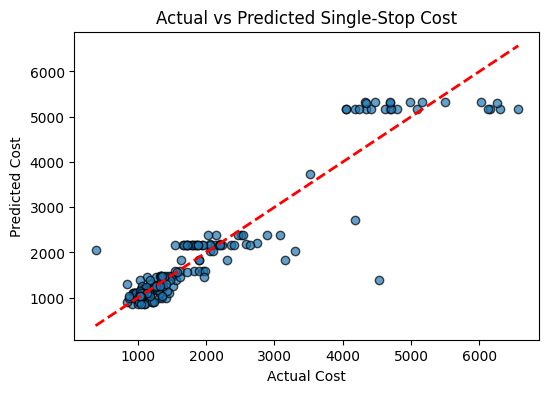

Savings Summary:
Total Separate Cost: 925469.37
Total Combined Cost: 610972.33
Total Saving: 314497.04
Total Freight Cost: 2657478.44
Global Saving Percentage: 11.83%


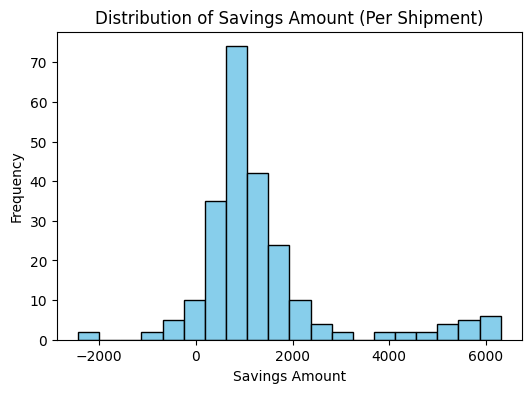


--- Decision Interface ---
Enter number of shipments to combine (1 or 2): 2

Shipment 1:
Enter destination city: Robbinsville
Enter destination state: NJ
Enter weight: 12576

Shipment 2:
Enter destination city: Nottingham
Enter destination state: MD
Enter weight: 20078



Decision Recommendation for New Shipments:
{'[Mode]': 'Multi-stop', '{Separate_cost]': 2555.7756973040186, '[Combined_cost]': 1569.4022942552633, '[Expected_saving]': 986.3734030487553, '[Expected_saving_pct]': 38.59389554761161}


In [3]:
# =============================================================================
# MAIN FUNCTION TO RUN ALL MODULES
# =============================================================================

def main():
    # Paths to the three datasets (all in the same directory)
    single_file_path = '/content/drive/MyDrive/6980/final_chr_singletrip_data.xlsx'
    multi_file_path  = '/content/drive/MyDrive/6980/final_chr_multitrip_data.xlsx'
    third_file_path  = '/content/drive/MyDrive/6980/Updated_Weather_CH Robinson.xlsx'

    # 1. Load Data
    single_df, multi_df = load_data(single_file_path, multi_file_path)
    third_df = load_third_data(third_file_path)

    # 2. Clean Data
    single_df = clean_single_data(single_df)
    multi_df = clean_multi_data(multi_df)
    single_df, multi_df = standardize_location_fields(single_df, multi_df)

    # 3. Match Single to Multi & Calculate Savings
    model_multi_df = match_single_to_multi(single_df, multi_df)

    # 4. Extract Date Features (so that Shipment_DayOfWeek is available)
    model_multi_df = extract_date_features(model_multi_df)

    # 5. Add Advanced Capacity Features (including scheduling constraints)
    model_multi_df = add_advanced_capacity_features(model_multi_df)

    # 6. Train Cost Prediction Model using Single-stop Data
    cost_model = train_cost_model(single_df)

    # 7. Generate Savings Report & Visualizations for Multi-stop Data,
    #    using the third dataset for total freight cost.
    report_df = generate_savings_report(model_multi_df, cost_model, third_df)

    # 8. Decision Interface Example - Allow user input interactively:
    print("\n--- Decision Interface ---")
    try:
        num_shipments = int(input("Enter number of shipments to combine (1 or 2): "))
    except ValueError:
        print("Invalid input. Defaulting to 1 shipment.")
        num_shipments = 1
    shipments = []
    for i in range(num_shipments):
        print(f"\nShipment {i+1}:")
        dest_city = input("Enter destination city: ").strip().upper()
        dest_state = input("Enter destination state: ").strip().upper()
        try:
            wt = float(input("Enter weight: "))
        except ValueError:
            print("Invalid weight. Defaulting to 0.")
            wt = 0
        shipments.append({"destination_city": dest_city, "destination_state": dest_state, "weight": wt})

    decision = recommend_transport_mode(shipments, cost_model)
    print("\nDecision Recommendation for New Shipments:")
    print(decision)

if __name__ == "__main__":
    main()


# Decision Interface Example
#
#        {"destination_city": "ATLANTA", "destination_state": "GA", "weight": 10000},
#        {"destination_city": "CHICAGO", "destination_state": "IL", "weight": 8000}
